In [ ]:
%autosave 0

### Kaggle - Web Traffic Time Series Forecasting

## Model 10 - Modified CNN with Fibonacci

### v4 The Model Beta

by Louis Yang

Use Fibonacci series median as the center of each data.

According to the center, split data into groups and train individual neural network (model) in each group.

The grouping split are log10(fib_med + 1) < (1.0 , 2.0, 4.0, rest) There are total 4 groups.

The first 1 groups use original Fibonacci median as prediction since it is difficult to learn. The rest groups use the trained CNN as prediction.

The neural network structure is: 

    1 Conv1D(120) with filter size 3 > Average pooling(2) > FC(120) > FC(120) > FC(63, linear).

Then do ensemble learning: Evaluate the same model 5 times and take the ensemble median.

v0 Feed second input (median and stdev) to the neural network after the CNN part.

Test on stage 2 data.

Original model: 'model_10_Modified_CNN_0_median_stdev'

In [3]:
model_name = 'model_10_Modified_CNN_4_The_Model'

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect
from tools import *

## Input

In [5]:
train_file = 'train_2.csv'

In [6]:
input_df = pd.read_csv('../data/' + train_file, nrows=1)

In [7]:
input_df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,...,37,58,25,23,25,47,44,26,24,21


In [8]:
input_df_dates = input_df.columns[1:]; input_df_dates

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25', '2017-08-26',
       '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
      dtype='object', length=793)

In [9]:
visits_dtype = {d: np.float32 for d in input_df_dates}

In [10]:
print('%%% Reading data '+ train_file + ' ... ', end = '', flush = True)
input_df = pd.read_csv('../data/' + train_file, engine='c', dtype=visits_dtype)
print('done!')

%%% Reading data train_2.csv ... done!


In [11]:
input_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


In [12]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 794 entries, Page to 2017-08-31
dtypes: float32(793), object(1)
memory usage: 439.9+ MB


## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [13]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [14]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

In [15]:
#test_length = 0  # for predicting
test_length = y_length  # for self testing

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

#### X

In [16]:
X_input_dates = input_df_dates[-x_length-test_length-364:-test_length-364]; #X_input_dates

In [17]:
X_input_first_day = X_input_dates[0]
X_input_final_day = X_input_dates[-1]
X_input_first_day, X_input_final_day

('2016-04-29', '2016-06-30')

In [18]:
daydiff(X_input_first_day, X_input_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [19]:
# X for output set
if test_length:
    X_output_dates = input_df_dates[-x_length-test_length:-test_length]
else:
    X_output_dates = input_df_dates[-x_length:]
#X_output_dates

In [20]:
X_output_first_day = X_output_dates[0]
X_output_final_day = X_output_dates[-1]
X_output_first_day, X_output_final_day

('2017-04-28', '2017-06-29')

In [21]:
daydiff(X_output_first_day, X_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [22]:
weekday(X_input_first_day), weekday(X_output_first_day)

(4, 4)

Should be the same

#### Y

In [23]:
Y_input_dates = input_df_dates[-test_length-364:-test_length-364+y_length]; #Y_input_dates

In [24]:
Y_input_first_day = Y_input_dates[0]
Y_input_final_day = Y_input_dates[-1]
Y_input_first_day, Y_input_final_day

('2016-07-01', '2016-09-01')

In [25]:
daydiff(Y_input_first_day, Y_input_final_day)

datetime.timedelta(-62)

In [26]:
# Y for output set
if test_length:
    Y_output_dates = input_df_dates[-test_length:]
else:
    Y_output_first_day = '2017-09-12'  ## Make sure it is correct when predicting !!!!!!!
    Y_output_dates = pd.Index(np.arange(np.datetime64(Y_output_first_day), 
                                        np.datetime64(Y_output_first_day)
                                        + np.timedelta64(y_length, 'D')).astype('str'))
#Y_output_dates

In [27]:
Y_output_first_day = Y_output_dates[0]
Y_output_final_day = Y_output_dates[-1]
Y_output_first_day, Y_output_final_day

('2017-06-30', '2017-08-31')

In [28]:
daydiff(Y_output_first_day, Y_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [29]:
weekday(Y_input_first_day), weekday(Y_output_first_day)

(4, 4)

Should be the same

## Fibonacci

#### Window Sizes

The window sizes are given by Ehsan https://www.kaggle.com/safavieh

In [30]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]
fib_length = max(windows)#; fib_length

#### Data selection

In this testing code, we did not include the last y_length days since in the real predicting stage, we don't know their visits.

In [31]:
if test_length:
    fib_output_dates = input_df_dates[-fib_length-test_length:-test_length]
else:
    fib_output_dates = input_df_dates[-fib_length:]
fib_input_dates = input_df_dates[-fib_length-test_length-364:-test_length-364]
fib_input_dates, fib_output_dates

(Index(['2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10', '2015-08-11',
        '2015-08-12', '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
        ...
        '2016-06-21', '2016-06-22', '2016-06-23', '2016-06-24', '2016-06-25',
        '2016-06-26', '2016-06-27', '2016-06-28', '2016-06-29', '2016-06-30'],
       dtype='object', length=329),
 Index(['2016-08-05', '2016-08-06', '2016-08-07', '2016-08-08', '2016-08-09',
        '2016-08-10', '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
        ...
        '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23', '2017-06-24',
        '2017-06-25', '2017-06-26', '2017-06-27', '2017-06-28', '2017-06-29'],
       dtype='object', length=329))

In [32]:
weekday(fib_input_dates[0]), weekday(fib_output_dates[0])

(4, 4)

In [33]:
fib_output_data = input_df[fib_output_dates].values; #fib_output_data

In [34]:
fib_input_data = input_df[fib_input_dates].values; #fib_input_data

#### Fibonacci median in each window

In [35]:
fib_input_median_list = np.array([np.nanmedian(fib_input_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [36]:
fib_output_median_list = np.array([np.nanmedian(fib_output_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


fib_input_median_list.T.shape

fib_output_median_na = np.nanmedian(fib_output_median_list.T, axis=-1)

fib_output_median_na

In [37]:
fib_input_median = np.nan_to_num(np.nanmedian(fib_input_median_list.T, axis=-1)); fib_input_median.shape

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

In [38]:
fib_output_median = np.nan_to_num(np.nanmedian(fib_output_median_list.T, axis=-1)); fib_output_median.shape

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

fib_input_median

fib_output_median

In [39]:
del fib_output_data
del fib_input_data
del fib_output_median_list
del fib_input_median_list
gc.collect()

0

We will use this as the center and part of the result

In [40]:
Y_input_fib = fib_input_median.reshape(-1,1)
Y_output_fib = fib_output_median.reshape(-1,1)

## Data Selection
Select x_length + y_length days of data as input or ouput set.

### Input and Output data

In [41]:
X_input_raw = input_df[X_input_dates].values
Y_input_raw = input_df[Y_input_dates].values
X_output_raw = input_df[X_output_dates].values
if test_length:
    Y_output_raw = input_df[Y_output_dates].values

##### Convert nan to number 0.

In [42]:
X_input_num = np.nan_to_num(X_input_raw)
Y_input_num = np.nan_to_num(Y_input_raw)
X_output_num = np.nan_to_num(X_output_raw)
if test_length:
    Y_output_num = np.nan_to_num(Y_output_raw)

## Transform Data

### Log

In [43]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [55]:
X_input_raw_log = log(X_input_raw)  # Contain nan
Y_input_raw_log = log(Y_input_raw)
X_output_raw_log = log(X_output_raw)
if test_length:
    Y_output_raw_log = log(Y_output_raw)

In [44]:
X_input_log = log(X_input_num)  # Do not contain nan
Y_input_log = log(Y_input_num)
X_output_log = log(X_output_num)
if test_length:
    Y_output_log = log(Y_output_num)

In [45]:
X_input_log

array([[ 1.20412004,  1.47712123,  1.27875364, ...,  1.27875364,
         1.38021123,  1.11394334],
       [ 1.36172783,  1.36172783,  1.82607484, ...,  1.39794004,
         1.23044896,  1.20412004],
       [ 0.84509802,  0.60206002,  0.30103001, ...,  0.77815127,
         0.30103001,  0.69897002],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

Z_input_data_log = log(Z_input_data_num)

##### Check Log transformation

In [46]:
print(X_input_log.shape, Y_input_log.shape, X_output_log.shape)
if test_length: print(Y_output_log.shape)

(145063, 63) (145063, 63) (145063, 63)
(145063, 63)


In [49]:
arr_info((X_input_log, Y_input_log, X_output_log))
if test_length: arr_info([Y_output_log])

shape, min, max, median, stdev
(145063, 63) 0.0 7.36566 2.1038 1.05642
(145063, 63) 0.0 7.82778 2.11059 1.02617
(145063, 63) 0.0 7.39148 2.09342 0.964542
shape, min, max, median, stdev
(145063, 63) 0.0 7.27115 2.0569 0.962351


In [109]:
#Check inverse log transformation
X_input_log_tt = unlog(X_input_log)
X_input_log_tt_dif = X_input_log_tt - X_input_num
X_input_log_tt_dif.min(), X_input_log_tt_dif.max(), np.median(X_input_log_tt_dif), np.std(X_input_log_tt_dif)

(-12.0, 10.0, 0.0, 0.020967843)

In [110]:
X_output_log_tt = unlog(X_output_log)
X_output_log_tt_dif = X_output_log_tt - X_output_num
X_output_log_tt_dif.min(), X_output_log_tt_dif.max(), np.median(X_output_log_tt_dif), np.std(X_output_log_tt_dif)

(-12.0, 14.0, 0.0, 0.020666324)

In [111]:
Y_input_log_tt = unlog(Y_input_log)
Y_input_log_tt_dif = Y_input_log_tt - Y_input_num
Y_input_log_tt_dif.min(), Y_input_log_tt_dif.max(), np.median(Y_input_log_tt_dif), np.std(Y_input_log_tt_dif)

(-28.0, 32.0, 0.0, 0.04619436)

In [112]:
Y_output_log_tt = unlog(Y_output_log)
Y_output_log_tt_dif = Y_output_log_tt - Y_output_num
Y_output_log_tt_dif.min(), Y_output_log_tt_dif.max(), np.median(Y_output_log_tt_dif), np.std(Y_output_log_tt_dif)

(-12.0, 9.0, 0.0, 0.017680053)

In [113]:
del X_input_log_tt; del X_input_log_tt_dif
del X_output_log_tt; del X_output_log_tt_dif
del Y_input_log_tt; del Y_input_log_tt_dif
del Y_output_log_tt; del Y_output_log_tt_dif
gc.collect()

326

There is some error (~10) due to float32 when unlog (exp) it. However, for those cases, the original number is about 10^7 so the relative error is still very small.

### Normalization (Center and Scale)

#### Center

In [52]:
output_center = log(fib_output_median).reshape(-1,1) # Fib. median as the center
#input_center = log(fib_input_median).reshape(-1,1)
input_center = output_center  # using output_center instead

In [54]:
X_input_center = input_center
Y_input_center = input_center
X_output_center = output_center
Y_output_center = output_center

In [84]:
output_center.shape

(145063, 1)

In [53]:
input_center, output_center

(array([[ 1.39794004],
        [ 1.37106788],
        [ 0.69897002],
        ..., 
        [ 1.5440681 ],
        [ 0.94200808],
        [ 1.08813608]], dtype=float32), array([[ 1.39794004],
        [ 1.37106788],
        [ 0.69897002],
        ..., 
        [ 1.5440681 ],
        [ 0.94200808],
        [ 1.08813608]], dtype=float32))

plt.scatter(X_input_center.reshape(-1),Y_input_center.reshape(-1))
plt.show()

Z_input_center = np.median(Z_input_data_log, axis=-1).reshape(-1,1)

Z_input_center.shape

#Use Regular Median as the Center for X
#Choice 1: Not including nan
X_input_center = np.nan_to_num(np.nanmedian(X_input_log, axis=-1)).reshape(-1,1)
X_output_center = np.nan_to_num(np.nanmedian(X_output_log, axis=-1)).reshape(-1,1)

#Choice 2: Including nan
#X_input_center = np.median(np.nan_to_num(X_input_log), axis=-1).reshape(-1,1)
#X_output_center = np.median(np.nan_to_num(X_output_log), axis=-1).reshape(-1,1)

Y_input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
Y_input_center  # remember sample-wised center

Y_output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
Y_output_center  # remember sample-wised center

#### Choice of default scale

In [56]:
default_input_scale = np.nanmedian(np.nanstd(X_input_raw_log, axis=-1))  # Do not include nan
default_input_scale

c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.17974041

In [57]:
default_output_scale = np.nanmedian(np.nanstd(X_output_raw_log, axis=-1))  # Do not include nan
default_output_scale

c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.16425449

In [58]:
default_scale = np.mean([default_input_scale, default_output_scale]); default_scale

0.17199746

#### Scale

In [62]:
#Choice 1: Treat nan as 0
input_scale = np.std(X_input_log, axis=-1).reshape(-1,1)
output_scale = np.std(X_output_log, axis=-1).reshape(-1,1)

#Choice 2: Not including nan
#input_scale = np.nan_to_num(np.nanstd(X_input_raw_log, axis=-1)).reshape(-1,1)
#output_scale = np.nan_to_num(np.nanstd(X_output_raw_log, axis=-1)).reshape(-1,1)

input_scale[input_scale == 0.0] = default_scale  # Prevent divid by zero 
output_scale[output_scale == 0.0] = default_scale  # Prevent divid by zero 

In [65]:
X_input_scale = input_scale
Y_input_scale = input_scale
X_output_scale = output_scale
Y_output_scale = output_scale

In [63]:
input_scale

array([[ 0.22042467],
       [ 0.19443031],
       [ 0.23390391],
       ..., 
       [ 0.17199746],
       [ 0.17199746],
       [ 0.17199746]], dtype=float32)

In [64]:
output_scale

array([[ 0.15715757],
       [ 0.23019141],
       [ 0.29932547],
       ..., 
       [ 0.30635026],
       [ 0.30876896],
       [ 0.41433722]], dtype=float32)

Z_input_scale = np.std(Z_input_data_log, axis=-1).reshape(-1,1)
Z_input_scale[Z_input_scale == 0.0] = default_input_scale  # Prevent divid by zero
Z_input_scale  # remember sample-wised scale

##### Check zero in scale

#Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

#Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

#### Shift by Center and Scale by Scale

In [68]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [69]:
# Normalize after nan->0
X_input = transform(X_input_log, X_input_center, X_input_scale)
X_output = transform(X_output_log, X_output_center, X_output_scale)
Y_input = transform(Y_input_log, Y_input_center, Y_input_scale)
if test_length:
    Y_output = transform(Y_output_log, Y_output_center, Y_output_scale)    

# Another choice: Normalize before nan->0
#X_input = np.nan_to_num(transform(X_input_raw_log, X_input_center, input_scale))
#X_output = np.nan_to_num(transform(X_output_raw_log, X_output_center, output_scale))
#Y_input = np.nan_to_num(transform(Y_input_raw_log, Y_input_center, input_scale))
#if test_length:
#    Y_output = np.nan_to_num(transform(Y_output_raw_log, Y_output_center, output_scale))

Note:

* If we take nan_to_num before transform, we make sure the nan got transformed into 0 but not the center.
* If we take nan_to_num after transform, nan trun into the center but not 0 of the original data.

examine(Y_input)

input_data_norm = transform(input_data_log, Y_input_center, input_scale)
output_data_norm = transform(output_data_log, Y_output_center, output_scale)

Z_input = transform(Z_input_data_log, Z_input_center, Z_input_scale)

##### Check median and stdev transformations

In [71]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

check_nan(X_input)  # Check if there is any nan in the input_data

#Check inverse scale transformation
X_input_unnorm = untransform(X_input, X_input_center, X_input_scale)
X_input_unnorm_dif = X_input_unnorm - X_input_log
X_input_unnorm_dif.min(), X_input_unnorm_dif.max()

#Check inverse scale transformation
Y_input_unnorm = untransform(Y_input, Y_input_center, Y_input_scale)
Y_input_unnorm_dif = Y_input_unnorm - Y_input_log
Y_input_unnorm_dif.min(), Y_input_unnorm_dif.max()

#Check inverse scale transformation
X_output_unnorm = untransform(X_output, X_output_center, X_output_scale)
X_output_unnorm_dif = X_output_unnorm - X_output_log
X_output_unnorm_dif.min(), X_output_unnorm_dif.max()

#Check inverse scale transformation
Y_output_unnorm = untransform(Y_output, Y_output_center, Y_output_scale)
Y_output_unnorm_dif = Y_output_unnorm - Y_output_log
Y_output_unnorm_dif.min(), Y_output_unnorm_dif.max()

del X_input_unnorm; del X_input_unnorm_dif
del Y_input_unnorm; del Y_input_unnorm_dif
del X_output_unnorm; del X_output_unnorm_dif
del Y_output_unnorm; del Y_output_unnorm_dif
gc.collect()

## Center (Median) and Scale (Stdev) Investigation

### Center

plt.hist(Y_input_center, bins=40, alpha=0.5, label='input')
plt.hist(Y_output_center, bins=40, alpha=0.5, label='output')
plt.hist(X_input_center, bins=40, alpha=0.5, label='input')
plt.hist(X_output_center, bins=40, alpha=0.5, label='output')
#plt.hist(Z_input_center, bins=40, alpha=0.5, label='Z_input')
plt.legend()
plt.show()

plt.hist(Y_input_center, bins=40, alpha=0.7, label='input')
plt.hist(Y_output_center, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Scale

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
#plt.hist(Z_input_scale, bins=40, alpha=0.7, label='Z_input')
plt.legend()
plt.show()

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

In [73]:
def group_index(logx):
    if logx < 1.0: return 0
    elif logx < 2.0: return 1
    elif logx < 4.0: return 2
    else: return 3
group_index_v = np.vectorize(group_index)
gp_list = list(range(4)); gp_list

[0, 1, 2, 3]

def group_index(median, stdev):
    if median < 1.0: return 0
    elif median < 2.0: 
        if stdev < 1.7: return 1
        else: return 2
    elif median < 4.0: 
        if stdev < 1.7: return 3
        else: return 4
    else: return 5
#group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 2.0: return 2
    elif logx < 4.0: return 3
    elif logx < 5.0: return 4
    else: return 5
group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

input_gp = np.array([group_index(center, scale) for center, scale in zip(Y_input_center, input_scale)]).reshape(-1)
output_gp = np.array([group_index(center, scale) for center, scale in zip(Y_output_center, output_scale)]).reshape(-1)

In [74]:
# Choice 1: Group using X center
input_gp = group_index_v(X_input_center).reshape(-1)
output_gp = group_index_v(X_output_center).reshape(-1)

# Choice 2: Group using Y center (Fib Median)
#input_gp = group_index_v(Y_input_center).reshape(-1)
#output_gp = group_index_v(Y_output_center).reshape(-1)

In [75]:
input_gp, output_gp

(array([1, 1, 0, ..., 1, 0, 1]), array([1, 1, 0, ..., 1, 0, 1]))

In [76]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
gp_input_counts

[24964, 43691, 75617, 791]

In [77]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
gp_output_counts

[24964, 43691, 75617, 791]

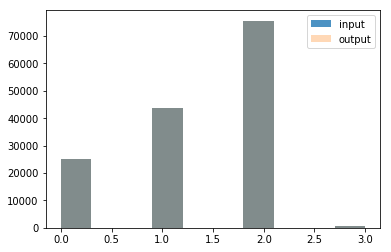

In [78]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

#### Original data

In [80]:
X_input_ori = X_input_num  # Do not contain nan
Y_input_ori = Y_input_num
X_output_ori = X_output_num
if test_length:
    Y_output_ori = Y_output_num

In [81]:
if test_length:
    arr_info((X_input, Y_input, X_output, Y_output, 
              X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))
else:
    arr_info((X_input, Y_input, X_output, 
              X_input_ori, Y_input_ori, X_output_ori))

shape, min, max, median, stdev
(145063, 63) -104.946 182.184 0.0250222 3.40356
(145063, 63) -104.946 181.97 -0.0156384 3.46894
(145063, 63) -57.3466 8.00102 0.0 1.25673
(145063, 63) -1627.74 51.3919 -0.214767 6.03368
(145063, 63) 0.0 2.32094e+07 126.0 63765.9
(145063, 63) 0.0 6.72643e+07 128.0 155484.0
(145063, 63) 0.0 2.46307e+07 123.0 65785.6
(145063, 63) 0.0 1.86702e+07 113.0 57469.1


arr_info((Z_input,))

#### Min and max cases examination

np.argmin(Y_output, axis=0)

Y_output[8604]

Y_output_ori[8604]

fib_output_median[8604]

log(Y_output_ori[8604])

log(fib_output_median[8604])

np.std(log(Y_output_ori[8604]))

np.std(log(X_output_ori[8604]))

output_scale[8604]

#### Check if the inverse transformation is correct

#Undo transformation
X_input_tt = unlog(untransform(X_input, X_input_center, X_input_scale))

X_input_tt_diff = X_input_tt - X_input_ori
X_input_tt_diff.min(), X_input_tt_diff.max()

del X_input_tt_diff; del X_input_tt

## Split X,Y data into groups

X_input[input_gp == 1].shape

In [115]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
if test_length:
    Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

Z_input_list = [Z_input[input_gp == gp] for gp in gp_list]
Z_output_list = [Z_output[output_gp == gp] for gp in gp_list]

## Additional input for the neural network

#Split center into group
Y_input_center_list = [Y_input_center[input_gp == gp] for gp in gp_list]
Y_output_center_list = [Y_output_center[output_gp == gp] for gp in gp_list]

#Split scale into group
input_scale_list = [input_scale[input_gp == gp] for gp in gp_list]
output_scale_list = [output_scale[output_gp == gp] for gp in gp_list]

input_scale_list[0].shape

In [116]:
A_input = np.concatenate((Y_input_center, input_scale), axis=1)
A_output = np.concatenate((Y_output_center, output_scale), axis=1); A_input.shape, A_output.shape

((145063, 2), (145063, 2))

In [117]:
A_input_list = [A_input[input_gp == gp] for gp in gp_list]
A_output_list = [A_output[output_gp == gp] for gp in gp_list]

In [118]:
a_length = len(A_input[0]); a_length

2

## Neural Network?

In [119]:
import keras

Using TensorFlow backend.


In [120]:
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam

### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [121]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(), None))
    return 200. * K.mean(diff, axis=-1)

In [122]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), np.float32(1e-07), None))
    return np.float32(200.) * np.nanmean(diff, axis=axis)

smape(np.array([0,1]),np.array([np.nan, 0])), smape(np.array([0]),np.array([0]))

In [123]:
# Benchmark SMAPE on the transformed data
smape(Y_input,X_input), smape(Y_input, X_output), smape(Y_input,Y_input)

(118.39848, 148.19083, 0.0)

In [124]:
# Benchmark SMAPE on the original data
smape(Y_input_raw,X_input_ori), smape(Y_input_ori,X_input_ori)

(60.41732, 58.828331)

In [125]:
if test_length: print(smape(Y_output_raw, X_output_ori), smape(Y_output, X_output))

50.9386 142.088


In [126]:
print(smape(Y_input_raw, Y_input_fib))
if test_length: print(smape(Y_output_raw, Y_output_fib))

48.325
40.4041


Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [127]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import concatenate

In [128]:
n_ens = 5
ens_list = list(range(n_ens))

In [129]:
#runbelow
models_ens = []
for run in ens_list:
    print('Run', run, end=': ')
    models = []
    for gp in gp_list:
        print('Group-', gp, sep='', end=' ')
        layer_0 = Input(shape=(x_length,), name='x_input')
        layer_t = Reshape((-1, 1))(layer_0)
        layer_t = Conv1D(120, kernel_size=3, activation='relu')(layer_t)
        layer_t = AveragePooling1D(pool_size=2)(layer_t)
        layer_cnn_x = Flatten()(layer_t)
        
        layer_a = Input(shape=(a_length,), name='a_input')
        
        #layer_z = Input(shape=(y_length,), name='z_input')
        #layer_t = Reshape((-1, 1))(layer_0)
        #layer_t = Conv1D(20, kernel_size=3, activation='relu')(layer_t)
        #layer_t = AveragePooling1D(pool_size=2)(layer_t)
        #layer_cnn_z = Flatten()(layer_t)
                
        layer_t = concatenate([layer_cnn_x, layer_a])#, layer_cnn_z])
        
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.25)(layer_t)
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.5)(layer_t)
        layer_f = Dense(y_length)(layer_t)
        
        model = Model(inputs=[layer_0, layer_a], outputs=layer_f)
        #model = Model(inputs=[layer_0, layer_a, layer_z], outputs=layer_f)
        model.compile(optimizer='adam',
                      loss='mean_absolute_error', metrics=[k_smape])
        #model.summary()
        models.append(model)
    models_ens.append(models)
    print('')

Run 0: Group-0 Group-1 Group-2 Group-3 
Run 1: Group-0 Group-1 Group-2 Group-3 
Run 2: Group-0 Group-1 Group-2 Group-3 
Run 3: Group-0 Group-1 Group-2 Group-3 
Run 4: Group-0 Group-1 Group-2 Group-3 


In [131]:
models_ens[-1][-1].summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
x_input (InputLayer)             (None, 63)            0                                            
____________________________________________________________________________________________________
reshape_20 (Reshape)             (None, 63, 1)         0           x_input[0][0]                    
____________________________________________________________________________________________________
conv1d_20 (Conv1D)               (None, 61, 120)       480         reshape_20[0][0]                 
____________________________________________________________________________________________________
average_pooling1d_20 (AveragePoo (None, 30, 120)       0           conv1d_20[0][0]                  
___________________________________________________________________________________________

In [132]:
np.array(models_ens).shape

(5, 4)

In [133]:
len(gp_list)

4

In [135]:
epochs_list = [1,40,40,60]  # change to smaller epochs later (1,1,20,40,60,80)

In [136]:
%%time
hists_ens = []
for run, models in zip(ens_list, models_ens):
    print('=== Run:', run+1, '/', len(ens_list), '===')
    hists = []
    for (gp, model, X_in, Y_in, epochs, A_in) in zip(gp_list, models,
                                       X_input_list, Y_input_list, 
                                       epochs_list, A_input_list):
        print('--- Group:', gp+1, '/', len(gp_list), '---')
        hist = model.fit([X_in, A_in], Y_in, batch_size=128, 
                         epochs=epochs, 
                         validation_split=0.1, verbose=2)
        #validation_data=(X_val, Y_val))
        hists.append(hist)
    hists_ens.append(hists)

=== Run: 1 / 5 ===
--- Group: 1 / 4 ---
Train on 22467 samples, validate on 2497 samples
Epoch 1/1
5s - loss: 1.1164 - k_smape: 149.6124 - val_loss: 0.9792 - val_k_smape: 136.8191
--- Group: 2 / 4 ---
Train on 39321 samples, validate on 4370 samples
Epoch 1/40
7s - loss: 1.3337 - k_smape: 127.6360 - val_loss: 1.0710 - val_k_smape: 122.4934
Epoch 2/40
7s - loss: 1.2494 - k_smape: 117.8058 - val_loss: 1.0478 - val_k_smape: 119.7648
Epoch 3/40
7s - loss: 1.2361 - k_smape: 116.2100 - val_loss: 1.0447 - val_k_smape: 117.8047
Epoch 4/40
7s - loss: 1.2270 - k_smape: 115.7089 - val_loss: 1.0386 - val_k_smape: 117.7164
Epoch 5/40
7s - loss: 1.2276 - k_smape: 115.5848 - val_loss: 1.0642 - val_k_smape: 118.5803
Epoch 6/40
7s - loss: 1.2102 - k_smape: 114.9531 - val_loss: 1.0851 - val_k_smape: 121.4482
Epoch 7/40
7s - loss: 1.2098 - k_smape: 114.8889 - val_loss: 1.0752 - val_k_smape: 121.2309
Epoch 8/40
7s - loss: 1.2101 - k_smape: 114.5847 - val_loss: 1.0669 - val_k_smape: 119.1178
Epoch 9/40
7s 

0s - loss: 1.9785 - k_smape: 108.2169 - val_loss: 2.5090 - val_k_smape: 104.3330
Epoch 8/60
0s - loss: 1.9101 - k_smape: 107.4761 - val_loss: 1.9884 - val_k_smape: 94.4055
Epoch 9/60
0s - loss: 1.8593 - k_smape: 103.4265 - val_loss: 2.1886 - val_k_smape: 97.5285
Epoch 10/60
0s - loss: 1.8219 - k_smape: 101.4820 - val_loss: 1.9091 - val_k_smape: 93.8960
Epoch 11/60
0s - loss: 1.7531 - k_smape: 100.5419 - val_loss: 1.9452 - val_k_smape: 92.5674
Epoch 12/60
0s - loss: 1.7448 - k_smape: 98.4997 - val_loss: 2.1420 - val_k_smape: 95.4790
Epoch 13/60
0s - loss: 1.7464 - k_smape: 97.2025 - val_loss: 1.7757 - val_k_smape: 92.1740
Epoch 14/60
0s - loss: 1.6889 - k_smape: 97.8937 - val_loss: 1.5458 - val_k_smape: 86.8454
Epoch 15/60
0s - loss: 1.7558 - k_smape: 94.5545 - val_loss: 2.1179 - val_k_smape: 96.4665
Epoch 16/60
0s - loss: 1.6077 - k_smape: 93.5115 - val_loss: 1.7528 - val_k_smape: 90.9361
Epoch 17/60
0s - loss: 1.6472 - k_smape: 93.6748 - val_loss: 1.5992 - val_k_smape: 85.0763
Epoch 1

7s - loss: 1.1609 - k_smape: 110.7348 - val_loss: 1.0518 - val_k_smape: 116.7888
Epoch 35/40
7s - loss: 1.1614 - k_smape: 110.6634 - val_loss: 1.0163 - val_k_smape: 116.9698
Epoch 36/40
7s - loss: 1.1790 - k_smape: 111.4070 - val_loss: 1.0344 - val_k_smape: 116.2783
Epoch 37/40
7s - loss: 1.1665 - k_smape: 110.7510 - val_loss: 1.0267 - val_k_smape: 115.3000
Epoch 38/40
7s - loss: 1.1581 - k_smape: 110.6101 - val_loss: 1.0558 - val_k_smape: 118.8579
Epoch 39/40
7s - loss: 1.1574 - k_smape: 110.3708 - val_loss: 1.0565 - val_k_smape: 120.0808
Epoch 40/40
7s - loss: 1.1605 - k_smape: 110.3245 - val_loss: 1.0212 - val_k_smape: 114.2772
--- Group: 3 / 4 ---
Train on 68055 samples, validate on 7562 samples
Epoch 1/40
12s - loss: 1.3523 - k_smape: 109.4919 - val_loss: 1.1143 - val_k_smape: 108.4603
Epoch 2/40
12s - loss: 1.2482 - k_smape: 100.8094 - val_loss: 1.1174 - val_k_smape: 106.5103
Epoch 3/40
12s - loss: 1.2333 - k_smape: 99.5621 - val_loss: 1.1300 - val_k_smape: 109.5682
Epoch 4/40
12

0s - loss: 1.4216 - k_smape: 83.0715 - val_loss: 1.4261 - val_k_smape: 76.9411
Epoch 44/60
0s - loss: 1.4357 - k_smape: 80.9302 - val_loss: 1.7688 - val_k_smape: 80.3448
Epoch 45/60
0s - loss: 1.4572 - k_smape: 80.8222 - val_loss: 1.5688 - val_k_smape: 79.9307
Epoch 46/60
0s - loss: 1.4575 - k_smape: 83.2038 - val_loss: 1.4577 - val_k_smape: 77.1436
Epoch 47/60
0s - loss: 1.4263 - k_smape: 79.8397 - val_loss: 1.5604 - val_k_smape: 80.3136
Epoch 48/60
0s - loss: 1.4084 - k_smape: 82.0180 - val_loss: 1.4804 - val_k_smape: 78.1105
Epoch 49/60
0s - loss: 1.3866 - k_smape: 78.9219 - val_loss: 1.5170 - val_k_smape: 79.0123
Epoch 50/60
0s - loss: 1.3577 - k_smape: 79.7794 - val_loss: 1.8029 - val_k_smape: 81.8656
Epoch 51/60
0s - loss: 1.4412 - k_smape: 81.6800 - val_loss: 1.4465 - val_k_smape: 78.6472
Epoch 52/60
0s - loss: 1.3301 - k_smape: 81.9870 - val_loss: 1.6646 - val_k_smape: 78.0018
Epoch 53/60
0s - loss: 1.3844 - k_smape: 78.1164 - val_loss: 1.5976 - val_k_smape: 76.4343
Epoch 54/60

12s - loss: 1.1586 - k_smape: 95.0028 - val_loss: 1.1399 - val_k_smape: 107.5495
Epoch 30/40
12s - loss: 1.1548 - k_smape: 94.8926 - val_loss: 1.1020 - val_k_smape: 104.5472
Epoch 31/40
12s - loss: 1.1505 - k_smape: 94.8226 - val_loss: 1.1297 - val_k_smape: 105.1856
Epoch 32/40
12s - loss: 1.1542 - k_smape: 94.8438 - val_loss: 1.1035 - val_k_smape: 103.4955
Epoch 33/40
12s - loss: 1.1547 - k_smape: 94.7594 - val_loss: 1.0767 - val_k_smape: 104.0242
Epoch 34/40
12s - loss: 1.1498 - k_smape: 94.7978 - val_loss: 1.0982 - val_k_smape: 104.6985
Epoch 35/40
12s - loss: 1.1487 - k_smape: 94.5496 - val_loss: 1.1050 - val_k_smape: 104.7558
Epoch 36/40
12s - loss: 1.1492 - k_smape: 94.6085 - val_loss: 1.1012 - val_k_smape: 104.2673
Epoch 37/40
12s - loss: 1.1457 - k_smape: 94.4507 - val_loss: 1.0910 - val_k_smape: 103.9238
Epoch 38/40
12s - loss: 1.1451 - k_smape: 94.5533 - val_loss: 1.0868 - val_k_smape: 104.0872
Epoch 39/40
12s - loss: 1.1430 - k_smape: 94.2779 - val_loss: 1.1163 - val_k_smape

7s - loss: 1.1884 - k_smape: 112.8916 - val_loss: 1.0656 - val_k_smape: 123.5668
Epoch 16/40
7s - loss: 1.1829 - k_smape: 112.5036 - val_loss: 1.0422 - val_k_smape: 117.6156
Epoch 17/40
7s - loss: 1.1847 - k_smape: 112.5004 - val_loss: 1.0463 - val_k_smape: 120.5732
Epoch 18/40
7s - loss: 1.1789 - k_smape: 112.1714 - val_loss: 1.0627 - val_k_smape: 120.3242
Epoch 19/40
7s - loss: 1.1796 - k_smape: 112.3726 - val_loss: 1.0494 - val_k_smape: 120.3440
Epoch 20/40
7s - loss: 1.1824 - k_smape: 112.3612 - val_loss: 1.0273 - val_k_smape: 116.7532
Epoch 21/40
7s - loss: 1.1806 - k_smape: 111.9388 - val_loss: 1.0380 - val_k_smape: 117.9867
Epoch 22/40
7s - loss: 1.1794 - k_smape: 112.0558 - val_loss: 1.0539 - val_k_smape: 119.0517
Epoch 23/40
7s - loss: 1.1784 - k_smape: 111.7633 - val_loss: 1.0637 - val_k_smape: 119.3032
Epoch 24/40
7s - loss: 1.1763 - k_smape: 111.7048 - val_loss: 1.0311 - val_k_smape: 116.4058
Epoch 25/40
7s - loss: 1.1781 - k_smape: 111.6103 - val_loss: 1.0381 - val_k_smape

0s - loss: 1.5836 - k_smape: 87.6841 - val_loss: 1.6203 - val_k_smape: 85.1084
Epoch 24/60
0s - loss: 1.4917 - k_smape: 88.7128 - val_loss: 1.8202 - val_k_smape: 86.6907
Epoch 25/60
0s - loss: 1.5238 - k_smape: 86.5328 - val_loss: 1.8097 - val_k_smape: 85.5670
Epoch 26/60
0s - loss: 1.5100 - k_smape: 87.2668 - val_loss: 1.6094 - val_k_smape: 84.3450
Epoch 27/60
0s - loss: 1.4676 - k_smape: 86.4367 - val_loss: 1.7653 - val_k_smape: 86.0627
Epoch 28/60
0s - loss: 1.5043 - k_smape: 85.2688 - val_loss: 1.9573 - val_k_smape: 84.2524
Epoch 29/60
0s - loss: 1.5678 - k_smape: 85.6049 - val_loss: 1.4962 - val_k_smape: 82.7953
Epoch 30/60
0s - loss: 1.5124 - k_smape: 85.5602 - val_loss: 1.6780 - val_k_smape: 83.1297
Epoch 31/60
0s - loss: 1.4336 - k_smape: 85.0056 - val_loss: 1.6042 - val_k_smape: 84.1756
Epoch 32/60
0s - loss: 1.4569 - k_smape: 84.0287 - val_loss: 1.4430 - val_k_smape: 80.8838
Epoch 33/60
0s - loss: 1.4550 - k_smape: 83.1376 - val_loss: 1.5368 - val_k_smape: 82.5047
Epoch 34/60

12s - loss: 1.1963 - k_smape: 96.7863 - val_loss: 1.1153 - val_k_smape: 105.1053
Epoch 10/40
12s - loss: 1.1962 - k_smape: 96.5853 - val_loss: 1.0765 - val_k_smape: 104.1473
Epoch 11/40
12s - loss: 1.1906 - k_smape: 96.4600 - val_loss: 1.1143 - val_k_smape: 105.5693
Epoch 12/40
12s - loss: 1.1893 - k_smape: 96.3904 - val_loss: 1.0797 - val_k_smape: 105.0463
Epoch 13/40
12s - loss: 1.1869 - k_smape: 96.1147 - val_loss: 1.1069 - val_k_smape: 105.3824
Epoch 14/40
12s - loss: 1.1820 - k_smape: 95.9452 - val_loss: 1.0783 - val_k_smape: 103.9573
Epoch 15/40
12s - loss: 1.1773 - k_smape: 95.9195 - val_loss: 1.0830 - val_k_smape: 102.8271
Epoch 16/40
12s - loss: 1.1804 - k_smape: 95.7385 - val_loss: 1.1049 - val_k_smape: 105.2888
Epoch 17/40
12s - loss: 1.1800 - k_smape: 95.7586 - val_loss: 1.0858 - val_k_smape: 104.1796
Epoch 18/40
12s - loss: 1.1738 - k_smape: 95.4644 - val_loss: 1.1002 - val_k_smape: 104.1433
Epoch 19/40
12s - loss: 1.1728 - k_smape: 95.5803 - val_loss: 1.1143 - val_k_smape

0s - loss: 1.3353 - k_smape: 79.0511 - val_loss: 1.8480 - val_k_smape: 82.6497
Epoch 60/60
0s - loss: 1.3823 - k_smape: 79.8417 - val_loss: 1.3945 - val_k_smape: 78.5528
Wall time: 1h 6min 17s


%%time
hists_ens = []
for run, models in zip(ens_list, models_ens):
    print('=== Run:', run+1, '/', len(ens_list), '===')
    hists = []
    for (gp, model, X_in, Y_in, epochs, A_in, Z_in) in zip(gp_list, models,
                                       X_input_list, Y_input_list, 
                                       epochs_list, A_input_list, Z_input_list):
        print('--- Group:', gp+1, '/', len(gp_list), '---')
        hist = model.fit([X_in, A_in, Z_in], Y_in, batch_size=128, 
                         epochs=epochs, 
                         validation_split=0.1, verbose=2)
        #validation_data=(X_val, Y_val))
        hists.append(hist)
    hists_ens.append(hists)

### Training History

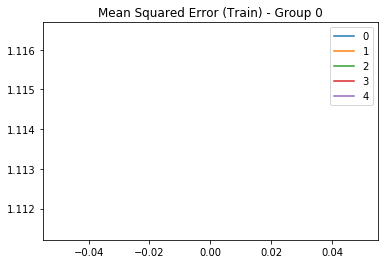

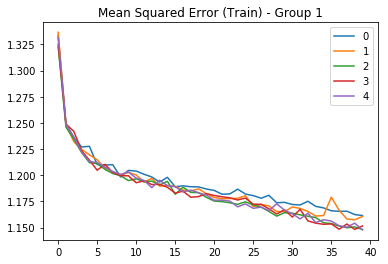

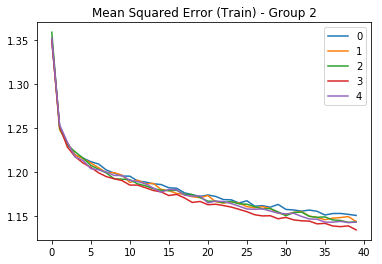

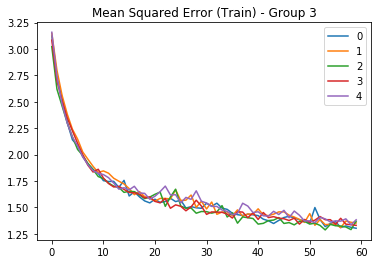

In [137]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['loss'], label=str(run))
        plt.title('Mean Squared Error (Train) - Group ' + str(gp))
        plt.legend(); plt.show()        

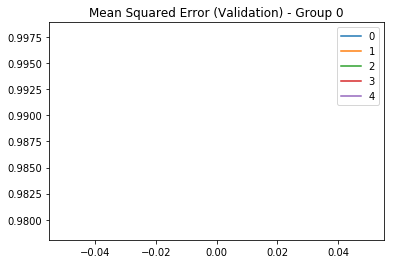

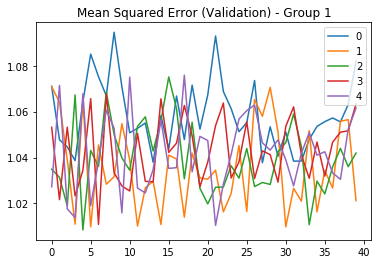

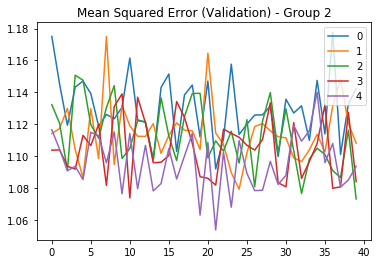

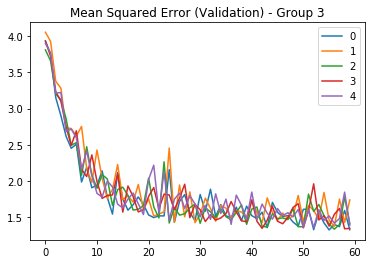

In [138]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_loss'], label=str(run))
        plt.title('Mean Squared Error (Validation) - Group ' + str(gp))
        plt.legend(); plt.show()        

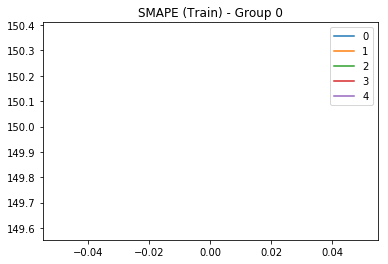

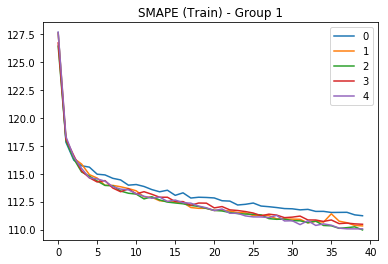

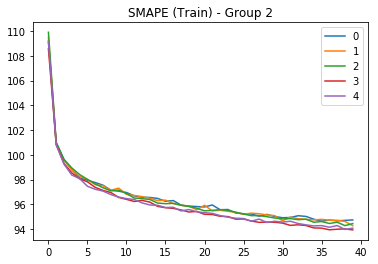

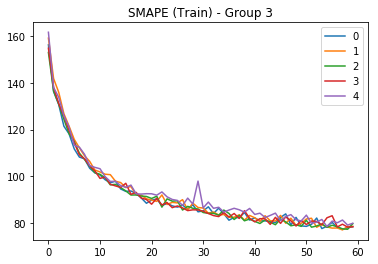

In [139]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['k_smape'], label=str(run))
        plt.title('SMAPE (Train) - Group ' + str(gp))
        plt.legend(); plt.show()        

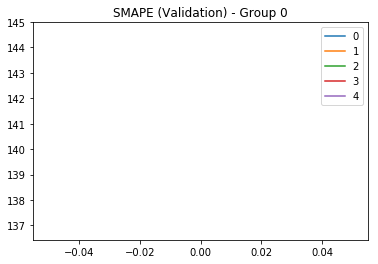

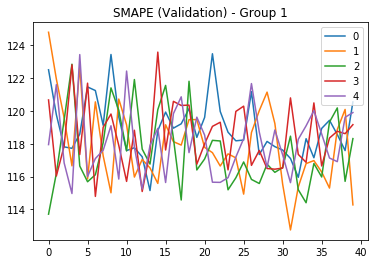

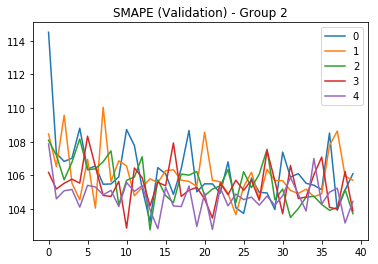

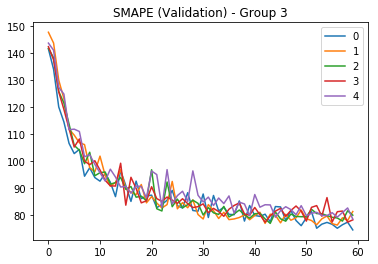

In [140]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_k_smape'], label=str(run))
        plt.title('SMAPE (Validation) - Group ' + str(gp))
        plt.legend(); plt.show()        

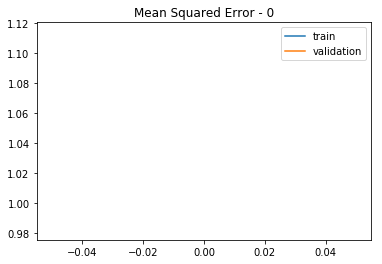

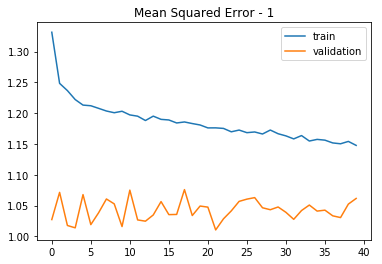

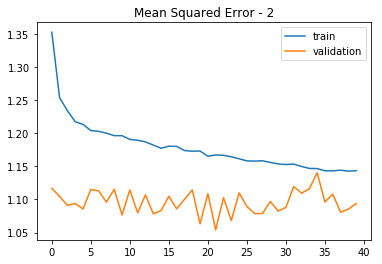

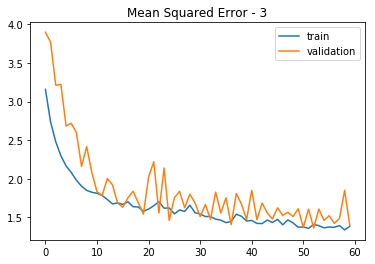

In [141]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

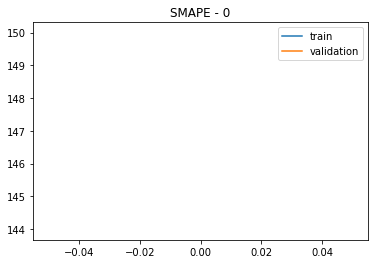

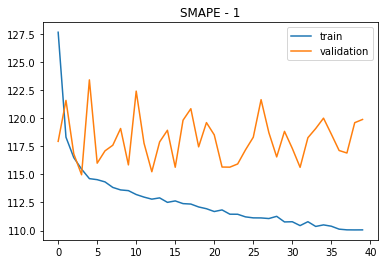

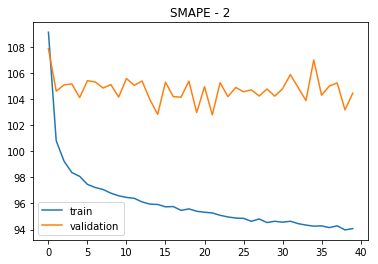

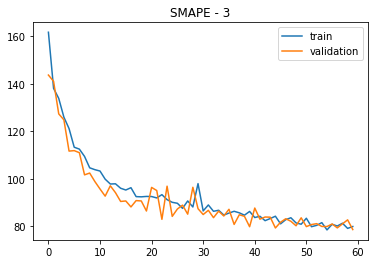

In [142]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

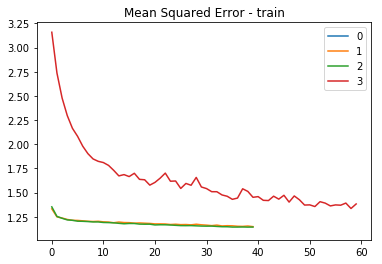

In [143]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

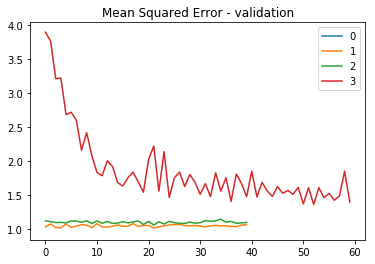

In [144]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

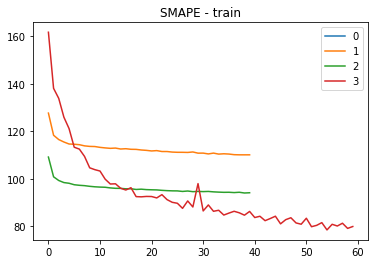

In [145]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

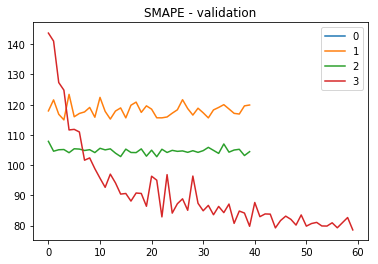

In [146]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

## Predict for Input Set (Training Set)

In [158]:
%%time
Y_input_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_input_pred_list = []
    for (gp, model, X, A) in zip(gp_list, models, X_input_list, A_input_list):
        print(gp, end=' ')
        Y_input_pred_list.append(model.predict([X, A]))
    Y_input_pred_list_ens.append(Y_input_pred_list)
    print('')

Run 0: 0 1 2 3 
Run 1: 0 1 2 3 
Run 2: 0 1 2 3 
Run 3: 0 1 2 3 
Run 4: 0 1 2 3 
Wall time: 46.7 s


%%time
Y_input_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_input_pred_list = []
    for (gp, model, X, A, Z) in zip(gp_list, models, X_input_list, A_input_list, Z_input_list):
        print(gp, end=' ')
        Y_input_pred_list.append(model.predict([X, A, Z]))
    Y_input_pred_list_ens.append(Y_input_pred_list)
    print('')

Find the original index

In [159]:
input_index_range = np.arange(len(input_gp)); #input_index_range

In [160]:
# list for original index
input_index_list = [input_index_range[input_gp == gp] 
                     for gp in gp_list]

In [161]:
for o in input_index_list:
    print(o.shape, end=' ')

(24964,) (43691,) (75617,) (791,) 

In [162]:
input_index_list_comb = np.concatenate(input_index_list); #input_index_list_comb

In [163]:
Y_input_pred_ens = []
for Y_input_pred_list in Y_input_pred_list_ens:
    Y_input_pred_comb = np.concatenate(Y_input_pred_list)
    Y_input_pred = [0]*len(input_index_list_comb)

    for index, y in zip(input_index_list_comb, Y_input_pred_comb):
        Y_input_pred[index] = y

    Y_input_pred = np.array(Y_input_pred)  # make it an numpy array (which will also make a copy)
    Y_input_pred_ens.append(Y_input_pred)

del Y_input_pred_comb

In [164]:
# Inverse transform Y_input_pred to original Y
Y_input_pred_ori_ens = []
for Y_input_pred in Y_input_pred_ens:
    Y_input_pred_ori = unlog(untransform(Y_input_pred, 
                                          Y_input_center, Y_input_scale))
    Y_input_pred_ori_ens.append(Y_input_pred_ori)

In [165]:
Y_input_pred_ori_ens = np.array(Y_input_pred_ori_ens)

## Predict for Output Set

In [147]:
%%time
Y_output_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_output_pred_list = []
    for (gp, model, X, A) in zip(gp_list, models, X_output_list, A_output_list):
        print(gp, end=' ')
        Y_output_pred_list.append(model.predict([X, A]))
    Y_output_pred_list_ens.append(Y_output_pred_list)
    print('')

Run 0: 0 1 2 3 
Run 1: 0 1 2 3 
Run 2: 0 1 2 3 
Run 3: 0 1 2 3 
Run 4: 0 1 2 3 
Wall time: 55.2 s


%%time
Y_output_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_output_pred_list = []
    for (gp, model, X, A, Z) in zip(gp_list, models, X_output_list, A_output_list, Z_output_list):
        print(gp, end=' ')
        Y_output_pred_list.append(model.predict([X, A, Z]))
    Y_output_pred_list_ens.append(Y_output_pred_list)
    print('')

Find the original index

In [148]:
output_index_range = np.arange(len(output_gp)); #output_index_range

In [149]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [150]:
for o in output_index_list:
    print(o.shape, end=' ')

(24964,) (43691,) (75617,) (791,) 

In [151]:
output_index_list_comb = np.concatenate(output_index_list); #output_index_list_comb

In [152]:
Y_output_pred_ens = []
for Y_output_pred_list in Y_output_pred_list_ens:
    Y_output_pred_comb = np.concatenate(Y_output_pred_list)
    Y_output_pred = [0]*len(output_index_list_comb)

    for index, y in zip(output_index_list_comb, Y_output_pred_comb):
        Y_output_pred[index] = y

    Y_output_pred = np.array(Y_output_pred)  # make it an numpy array (which will also make a copy)
    Y_output_pred_ens.append(Y_output_pred)

del Y_output_pred_comb

In [153]:
# Inverse transform Y_output_pred to original Y
Y_output_pred_ori_ens = []
for Y_output_pred in Y_output_pred_ens:
    Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                          Y_output_center, Y_output_scale))
    Y_output_pred_ori_ens.append(Y_output_pred_ori)

In [166]:
Y_output_pred_ori_ens = np.array(Y_output_pred_ori_ens)

#### Check predict output

Y_output_pred

Y_output_pred_ori

examine(Y_output_pred)

examine(Y_output_pred_ori)

view(X_output_ori[126420])

## SMAPE Scores

### Model Score

In [232]:
# SMAPE scores for the model
if test_length:
    model_smape_ens = []
    model_smape_0_ens = []
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        model_smape = smape(Y_output_raw, Y_output_pred_ori) # SMAPE score excluding nan (Correct one)
        model_smape_0 = smape(Y_output_ori, Y_output_pred_ori) # SMAPE assuming nan == 0
        
        model_smape_ens.append(model_smape)
        model_smape_0_ens.append(model_smape_0)
    model_smape_ens_mean = np.mean(model_smape_ens)
    model_smape_0_ens_mean = np.mean(model_smape_0_ens)
    
    model_smape_stdev = np.std(model_smape_ens)  # standard deviation of the smape score
    model_smape_0_stdev = np.std(model_smape_0_ens)  # standard deviation of the smape score
    
    model_smape_ens_mean_std = model_smape_stdev / np.sqrt(len(model_smape_ens))

In [233]:
if test_length:
    for model_smape, model_smape_0 in zip(model_smape_ens, model_smape_0_ens):
        print('%6.3f' % model_smape, '       ', '%6.3f' % model_smape_0)
    print('-----------------------------')
    print('%6.3f' % model_smape_ens_mean, '+-%5.3f' % model_smape_stdev, 
          '%6.3f' % model_smape_0_ens_mean, '+-%5.3f' % model_smape_0_stdev)
    print('+-%5.3f' % model_smape_ens_mean_std)

38.826         42.277
38.677         42.338
38.829         42.346
38.889         42.428
38.957         42.558
-----------------------------
38.836 +-0.093 42.389 +-0.097
+-0.041


In [155]:
# SMAPE score for Fibonacci median
if test_length:
    fib_smape = smape(Y_output_raw, Y_output_fib)
    print(fib_smape)

40.4041


In [239]:
 (16.406 +  16.451 +  17.309 +  16.628 +  16.331)/5

16.625

### Group Scores

In [156]:
# Prediction Y_output in group
Y_output_pred_ori_list_ens = [[Y_output_pred_ori[output_gp == gp] for gp in gp_list]
                              for Y_output_pred_ori in Y_output_pred_ori_ens]
#Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]
Y_output_pred_ori_list = Y_output_pred_ori_list_ens[-1]  # in case you want to see one of them

In [157]:
# Fibonacci median in group
Y_output_fib_list = [Y_output_fib[output_gp == gp] for gp in gp_list]

In [167]:
# True Y_output in group
if test_length:
    # untransformed Y_output with nan replaced by 0
    Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]
    
    # untransformed Y_output_ori with nan (for SMAPE estimation)
    Y_output_raw_list = [Y_output_raw[output_gp == gp] for gp in gp_list]

In [168]:
tot_n = len(output_gp); tot_n  # total number of pages in output set

145063

In [169]:
def count_not_nan(data):
    return np.count_nonzero(~np.isnan(data))

if test_length: print(count_not_nan(Y_output_raw))

In [170]:
# Group scores for the model
if test_length:
    gp_n = [len(Y) for Y in Y_output_raw_list]
    # SMAPE with nan values ignored (used by Kaggle)
    gp_smape_ens = [[smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list)]
                    for Y_output_pred_ori_list in Y_output_pred_ori_list_ens]
    gp_smape = gp_smape_ens[-1]    

In [171]:
gp_smape_mean = np.mean(gp_smape_ens, axis=0); gp_smape_mean

array([ 68.29080963,  39.9863472 ,  29.63250351,  33.30838776], dtype=float32)

if test_length:
    #gp_smape = [smape(Y, Y_p) for Y, Y_p 
    #            in zip(Y_output_raw_list, Y_output_pred_ori_list)]
    
    #n_not_nan = count_not_nan(Y_output_raw)
    #n_not_nan_gp = [count_not_nan(Y) for Y in Y_output_raw_list]
    #n_not_nan_ratio_gp = [n / (len(Y) * len(Y[0])) for Y,n 
    #                      in zip(Y_output_raw_list, n_not_nan_gp)]
    
    # SMAPE contribution
    #gp_smape_sum = [s * n for n, s in zip(gp_smape, n_not_nan_gp)]
    #gp_smape_cont = [s / n_not_nan for s in gp_smape_sum]

In [172]:
# Group score for Fibonacci median
if test_length:
    gp_smape_fib = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_fib_list)]

In [173]:
if test_length:  # gp_score compare
    print('#### ' + model_name)
    print('', end='|')
    print('N_pages ', 'Fibonacci', ' Average ', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')
    print('|  Total ', ' %7.3f ' % fib_smape, ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')
    for run in ens_list:
            print(' %7.3f ' % model_smape_ens[run], end='|')

#### model_10_Modified_CNN_4_The_Model
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.291 |  68.432 |  67.965 |  68.039 |  68.527 |  68.492 |
|  43691 |  40.612 |  39.986 |  39.863 |  39.935 |  40.101 |  39.696 |  40.336 |
|  75617 |  34.284 |  29.633 |  29.641 |  29.453 |  29.630 |  29.832 |  29.606 |
|    791 |  34.653 |  33.308 |  33.714 |  33.951 |  32.934 |  33.296 |  32.647 |
|  Total |  40.404 |  38.836 |  38.826 |  38.677 |  38.829 |  38.889 |  38.957 |

#### model_10_Modified_CNN_4_The_Model
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.291 |  68.432 |  67.965 |  68.039 |  68.527 |  68.492 |
|  43691 |  40.612 |  39.986 |  39.863 |  39.935 |  40.101 |  39.696 |  40.336 |
|  75617 |  34.284 |  29.633 |  29.641 |  29.453 |  29.630 |  29.832 |  29.606 |
|    791 |  34.653 |  33.308 |  33.714 |  33.951 |  32.934 |  33.296 |  32.647 |
|  Total |  40.404 |  38.836 |  38.826 |  38.677 |  38.829 |  38.889 |  38.957 |
#### model_10_Modified_CNN_1_Z
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 158.876 | 166.920 | 167.117 | 154.478 | 165.189 | 140.678 |
|  23085 |  61.354 |  64.057 |  63.166 |  63.533 |  63.921 |  64.384 |  65.282 |
|  43691 |  40.612 |  40.025 |  40.088 |  39.890 |  40.224 |  40.132 |  39.794 |
|  75617 |  34.284 |  29.755 |  29.759 |  29.741 |  29.658 |  29.865 |  29.752 |
|    740 |  35.621 |  33.983 |  33.411 |  33.945 |  34.447 |  34.013 |  34.100 |
|     51 |  20.224 |  17.259 |  17.687 |  17.204 |  17.227 |  17.300 |  16.878 |
|  Total |  40.404 |  38.937 |  38.881 |  38.869 |  38.897 |  39.122 |  38.914 |
#### model_10_Modified_CNN_0_median_stdev_2_3_groups
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.900 |  69.367 |  69.103 |  69.194 |  69.001 |  67.833 |
|  43691 |  40.612 |  40.247 |  39.939 |  40.098 |  40.056 |  40.701 |  40.443 |
|  76408 |  34.288 |  29.910 |  29.979 |  30.039 |  29.790 |  29.676 |  30.068 |
|  Total |  40.404 |  39.140 |  39.154 |  39.194 |  39.062 |  39.169 |  39.119 |
#### model_10_Modified_CNN_0_median_stdev
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 161.576 | 156.487 | 166.024 | 139.355 | 159.019 |
|  23085 |  61.354 |  64.389 |  64.273 |  64.008 |  63.988 |  64.148 |
|  43691 |  40.612 |  39.684 |  39.842 |  39.969 |  39.808 |  40.173 |
|  75617 |  34.284 |  29.538 |  29.575 |  29.454 |  29.907 |  29.573 |
|    740 |  35.621 |  33.564 |  33.710 |  33.397 |  33.666 |  33.965 |
|     51 |  20.224 |  16.406 |  16.451 |  17.309 |  16.628 |  16.331 |
#### model_9_CNN_with_Fibonacci_4_Ensemble_3_filter_3
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 161.230 | 166.806 | 139.008 | 152.935 | 170.833 |
|  23085 |  61.354 |  64.048 |  63.281 |  63.966 |  63.664 |  63.569 |
|  43691 |  40.612 |  40.004 |  39.860 |  40.201 |  39.817 |  40.143 |
|  75617 |  34.284 |  30.201 |  29.582 |  29.611 |  29.744 |  29.618 |
|    740 |  35.621 |  33.801 |  34.143 |  34.101 |  34.290 |  34.145 |
|     51 |  20.224 |  16.933 |  17.094 |  16.930 |  17.424 |  16.985 |

#### model_9_CNN_with_Fibonacci_4_Ensemble
|N_pages |Fibonacci| Model 0 |
|--------|---------|---------|
|   1879 |  57.385 | 146.145 |
|  23085 |  61.354 |  64.128 |
|  43691 |  40.612 |  40.052 |
|  75617 |  34.284 |  29.862 |
|    740 |  35.621 |  34.607 |
|     51 |  20.224 |  16.023 |

if test_length:
    print('[Group SMAPE]')
    print('W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio')
    for score, score_0, c, n, nr in zip(gp_smape, gp_smape_0,
                                    gp_smape_cont, gp_n, 
                                    n_not_nan_ratio_gp):
        print('%6.2f' % score, '%6.2f' % score_0, '       %6.2f' % c, '%6d' % n,
              '        %6.3f' % nr)
    print('-------------------------------------------------')
    print('%6.2f' % model_smape, '%6.2f' % model_smape_0)

n_not_nan_gp

### Page Scores

In [174]:
if test_length:  # Page scores for the model
    smape_Y_pred_ens = []
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        smape_Y_pred = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                               in zip(Y_output_pred_ori, Y_output_raw)]))
        smape_Y_pred_ens.append(smape_Y_pred)

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [175]:
if test_length:  # Page score for Fib.
    smape_Y_fib = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                          in zip(Y_output_fib, Y_output_raw)]))

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


if test_length:
    for smape_Y_pred in smape_Y_pred_ens:
        plt.hist(smape_Y_pred, bins=40, alpha=0.4)
        #plt.yscale('log')
    plt.title('Ensemble Page SMAPE'); plt.show()

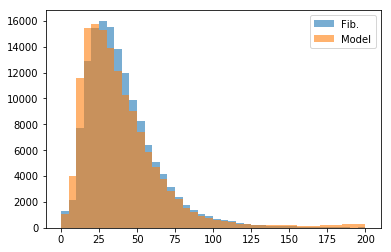

In [176]:
if test_length:
    plt.hist(smape_Y_fib, bins=40, alpha=0.6, label='Fib.')
    plt.hist(smape_Y_pred, bins=40, alpha=0.6, label='Model')
    #plt.yscale('log')
    plt.legend(); plt.show()

### Page Scores in Each Group

In [177]:
if test_length:  # The model
    smape_Y_pred_list_ens = []
    for smape_Y_pred in smape_Y_pred_ens:
        smape_Y_pred_list = [smape_Y_pred[output_gp == gp] for gp in gp_list]
        smape_Y_pred_list_ens.append(smape_Y_pred_list)

In [178]:
if test_length:  # Fib.
    smape_Y_fib_list = [smape_Y_fib[output_gp == gp] for gp in gp_list]

#### Plots

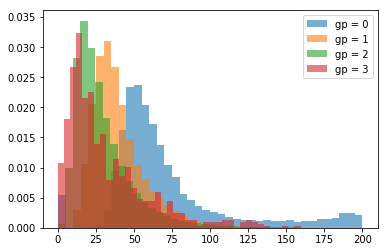

In [179]:
if test_length:
    for gp,s in zip(gp_list,smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label='gp = ' + str(gp))
    #plt.yscale('log')
    plt.legend(); plt.show()

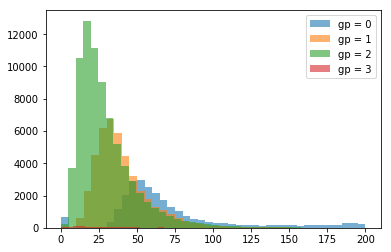

In [180]:
if test_length:
    for gp,s in zip(gp_list,smape_Y_pred_list):
        plt.hist(s, bins=40, alpha=0.6, label='gp = ' + str(gp))
    #plt.yscale('log')
    plt.legend(); plt.show()

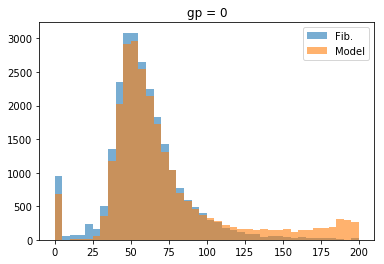

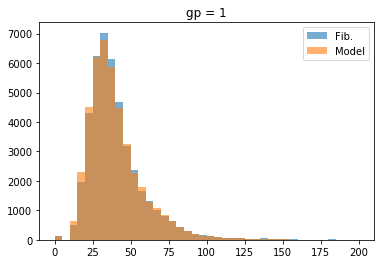

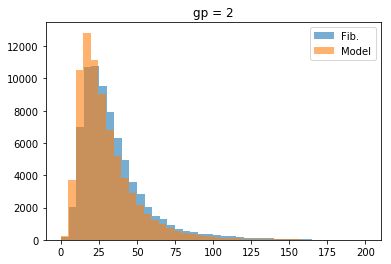

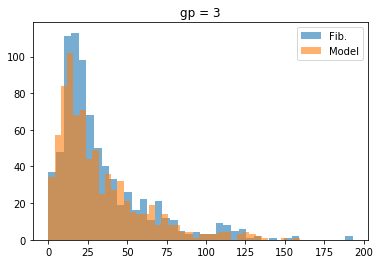

In [181]:
if test_length:
    for gp in gp_list:
        plt.hist(smape_Y_fib_list[gp], bins=40, alpha=0.6, label='Fib.')
        plt.hist(smape_Y_pred_list[gp], bins=40, alpha=0.6, label='Model')
        plt.title('gp = '+str(gp)); plt.legend()
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

## Prediction Pre Combine
Combine group 0, 1 from Fib and rest from the model

Y_output_fib.shape

In [182]:
Y_output_fib_ori = np.repeat(Y_output_fib, y_length, axis=1); Y_output_fib_ori.shape

(145063, 63)

In [183]:
# Select group 0 from Fib.
fib_mask = (output_gp == 0).reshape(-1,1); fib_mask.shape
#fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [184]:
# The combined result
Y_output_fmc_ori_ens = []
for Y_output_pred_ori in Y_output_pred_ori_ens:
    
    Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori
    
    Y_output_fmc_ori_ens.append(Y_output_fmc_ori)

Y_output_fmc_ori

#### Pre Combined Score

In [185]:
if test_length: 
    fmc_smape_ens = []
    for Y_output_fmc_ori in Y_output_fmc_ori_ens:
        fmc_smape = smape(Y_output_fmc_ori, Y_output_raw)
        fmc_smape_ens.append(fmc_smape)        
    fmc_smape_ens_mean = np.mean(fmc_smape_ens)

In [186]:
if test_length: 
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')

37.699 (38.826) - model_10_Modified_CNN_4_The_Model 0
37.623 (38.677) - model_10_Modified_CNN_4_The_Model 1
37.763 (38.829) - model_10_Modified_CNN_4_The_Model 2
37.748 (38.889) - model_10_Modified_CNN_4_The_Model 3
37.821 (38.957) - model_10_Modified_CNN_4_The_Model 4
37.731 (38.836) - model_10_Modified_CNN_4_The_Model Average


## Ensemble Learning

### Ensemble Median

In [187]:
Y_output_pred_ori_ens_med = np.median(Y_output_pred_ori_ens, axis=0)
Y_output_pred_ori_ens_med.shape

(145063, 63)

Y_output_pred_ori_ens_med

In [188]:
ens_med_smape = smape(Y_output_pred_ori_ens_med, Y_output_raw); ens_med_smape

38.535641

Best ways seem to be taking median either before or after transformation.

### Ensemble Combine with Fibonacci Median

In [189]:
#Replace group 0 by Fib. Median
fib_mask = ((output_gp == 0)).reshape(-1,1); fib_mask.shape
#fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [190]:
#Y_output_f_omean = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_mean
Y_output_f_omed  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_med  # Our final output
#Y_output_f_meano = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ens_mean_ori
#Y_output_f_medo  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ens_med_ori

## All Model Scores

In [191]:
if test_length:  # Ensemble learning model score
    #f_omean_smape = smape(Y_output_raw, Y_output_f_omean)
    f_omed_smape = smape(Y_output_raw, Y_output_f_omed)
    #f_meano_smape = smape(Y_output_raw, Y_output_f_meano)
    #f_medo_smape = smape(Y_output_raw, Y_output_f_medo)

In [192]:
if test_length: # The_score with (without) combining Fibonacci median model
    #print('%6.3f         ' % f_omean_smape, '-', model_name, 'ori_ens_mean')
    print('%6.3f' % f_omed_smape, '(%6.3f)' % ens_med_smape,'-', model_name, 'ori_ensemble_median')
    #print('%6.3f         ' % f_meano_smape, '-', model_name, 'ens_mean_ori')
    #print('%6.3f         ' % f_medo_smape, '-', model_name, 'ens_med_ori')
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)

37.429 (38.536) - model_10_Modified_CNN_4_The_Model ori_ensemble_median
37.731 (38.836) - model_10_Modified_CNN_4_The_Model Average
37.699 (38.826) - model_10_Modified_CNN_4_The_Model 0
37.623 (38.677) - model_10_Modified_CNN_4_The_Model 1
37.763 (38.829) - model_10_Modified_CNN_4_The_Model 2
37.748 (38.889) - model_10_Modified_CNN_4_The_Model 3
37.821 (38.957) - model_10_Modified_CNN_4_The_Model 4


37.429 (38.536) - model_10_Modified_CNN_4_The_Model ori_ensemble_median
37.731 (38.836) - model_10_Modified_CNN_4_The_Model Average
37.699 (38.826) - model_10_Modified_CNN_4_The_Model 0
37.623 (38.677) - model_10_Modified_CNN_4_The_Model 1
37.763 (38.829) - model_10_Modified_CNN_4_The_Model 2
37.748 (38.889) - model_10_Modified_CNN_4_The_Model 3
37.821 (38.957) - model_10_Modified_CNN_4_The_Model 4

37.436          - model_10_Modified_CNN_0_median_stdev ori_ens_mean
37.382          - model_10_Modified_CNN_0_median_stdev ori_ens_med
37.394          - model_10_Modified_CNN_0_median_stdev ens_mean_ori
37.382          - model_10_Modified_CNN_0_median_stdev ens_med_ori
37.687 (38.816) - model_10_Modified_CNN_0_median_stdev Average

Ensemble of model are all better than the individual model.

fmc_smape_ens

fmc_smape_ens_mean

 Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]

#### Combined Scores:
37.473          - model_10_Modified_CNN_1_Z ori_ensemble_median

37.535          - model_10_Modified_CNN_0_median_stdev_2_3_groups ori_ensemble_median

37.382          - model_10_Modified_CNN_0_median_stdev ori_ens_med

37.687 (38.816) - model_10_Modified_CNN_0_median_stdev Average

38.734 (39.415) - Model 9.1.0 - model_9_CNN_with_Fibonacci_1_no_group 1

38.227 (39.321) - Model 9.0.0 - model_9_CNN_with_Fibonacci_0_separate_Fib_median 1

43.009 (44.180) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 2

44.070 (45.335) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 1

44.473 (45.652) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 1

44.433 - Model 7.5.0 - model_7_CNN_with_Fibonacci_5_Deeper_0_Initial

44.168 - Model 7.2.0

## All Group Scores

In [193]:
# ensemble result Y_output in each group
#Y_output_pred_ori_ens_mean_list = [Y_output_pred_ori_ens_mean[output_gp == gp] for gp in gp_list]
Y_output_pred_ori_ens_med_list = [Y_output_pred_ori_ens_med[output_gp == gp] for gp in gp_list]
#Y_output_pred_ens_mean_ori_list = [Y_output_pred_ens_mean_ori[output_gp == gp] for gp in gp_list]
#Y_output_pred_ens_med_ori_list = [Y_output_pred_ens_med_ori[output_gp == gp] for gp in gp_list]

In [194]:
# Group SMAPE scores
if test_length:
    # SMAPE with nan values ignored (used by Kaggle)
    #gp_omean_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_ens_mean_list)]
    gp_omed_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_ens_med_list)]
    #gp_meano_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ens_mean_ori_list)]


In [195]:
if test_length:  # The_gp_score
    print('#### ' + model_name)
    print('', end='|')
    print(' N_pages', 'Fibonacci', 'Ens Media', ' Average ', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        #print(' %7.3f ' % gp_omean_smape[gp], end='|')
        print(' %7.3f ' % gp_omed_smape[gp], end='|')
        #print(' %7.3f ' % gp_meano_smape[gp], end='|')
        #print(' %7.3f ' % gp_medo_smape[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')
    print('|Over All', ' %7.3f ' % fib_smape, ' %7.3f ' % f_omed_smape,
          ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')
    for run in ens_list:
            print(' %7.3f ' % model_smape_ens[run], end='|')

# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

#### model_10_Modified_CNN_4_The_Model
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.304 |  68.291 |  68.432 |  67.965 |  68.039 |  68.527 |  68.492 |
|  43691 |  40.612 |  39.627 |  39.986 |  39.863 |  39.935 |  40.101 |  39.696 |  40.336 |
|  75617 |  34.284 |  29.275 |  29.633 |  29.641 |  29.453 |  29.630 |  29.832 |  29.606 |
|    791 |  34.653 |  33.112 |  33.308 |  33.714 |  33.951 |  32.934 |  33.296 |  32.647 |
|Over All|  40.404 |  37.429 |  38.836 |  38.826 |  38.677 |  38.829 |  38.889 |  38.957 |

#### model_10_Modified_CNN_4_The_Model
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.304 |  68.291 |  68.432 |  67.965 |  68.039 |  68.527 |  68.492 |
|  43691 |  40.612 |  39.627 |  39.986 |  39.863 |  39.935 |  40.101 |  39.696 |  40.336 |
|  75617 |  34.284 |  29.275 |  29.633 |  29.641 |  29.453 |  29.630 |  29.832 |  29.606 |
|    791 |  34.653 |  33.112 |  33.308 |  33.714 |  33.951 |  32.934 |  33.296 |  32.647 |
|Over All|  40.404 |  37.429 |  38.836 |  38.826 |  38.677 |  38.829 |  38.889 |  38.957 |
#### model_10_Modified_CNN_0_median_stdev_2_3_groups
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.909 |  68.900 |  69.367 |  69.103 |  69.194 |  69.001 |  67.833 |
|  43691 |  40.612 |  39.821 |  40.247 |  39.939 |  40.098 |  40.056 |  40.701 |  40.443 |
|  76408 |  34.288 |  29.400 |  29.910 |  29.979 |  30.039 |  29.790 |  29.676 |  30.068 |
|Over All|  40.404 |  37.535 |  39.140 |  39.154 |  39.194 |  39.062 |  39.169 |  39.119 |
#### model_10_Modified_CNN_0_median_stdev
| N_pages|Fibonacci| ori mean|ori media| mean ori|media ori| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 199.741 | 172.496 | 191.624 | 172.496 | 161.576 | 156.487 | 166.024 | 139.355 | 159.019 |
|  23085 |  61.354 |  64.110 |  64.122 |  64.116 |  64.122 |  64.389 |  64.273 |  64.008 |  63.988 |  64.148 |
|  43691 |  40.612 |  39.620 |  39.564 |  39.574 |  39.564 |  39.684 |  39.842 |  39.969 |  39.808 |  40.173 |
|  75617 |  34.284 |  29.300 |  29.231 |  29.248 |  29.231 |  29.538 |  29.575 |  29.454 |  29.907 |  29.573 |
|    740 |  35.621 |  33.403 |  33.482 |  33.373 |  33.482 |  33.564 |  33.710 |  33.397 |  33.666 |  33.965 |
|     51 |  20.224 |  16.360 |  16.338 |  16.361 |  16.338 |  16.406 |  16.451 |  17.309 |  16.628 |  16.331 |
#### model_9_CNN_with_Fibonacci_4_Ensemble_3_filter_3
| N_pages|Fibonacci| ori mean|ori media| mean ori|media ori| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 199.921 | 173.799 | 189.346 | 173.799 | 161.230 | 166.806 | 139.008 | 152.935 | 170.833 |
|  23085 |  61.354 |  63.635 |  63.651 |  63.644 |  63.651 |  64.048 |  63.281 |  63.966 |  63.664 |  63.569 |
|  43691 |  40.612 |  39.693 |  39.628 |  39.637 |  39.628 |  40.004 |  39.860 |  40.201 |  39.817 |  40.143 |
|  75617 |  34.284 |  29.444 |  29.368 |  29.381 |  29.368 |  30.201 |  29.582 |  29.611 |  29.744 |  29.618 |
|    740 |  35.621 |  33.858 |  33.893 |  33.837 |  33.893 |  33.801 |  34.143 |  34.101 |  34.290 |  34.145 |
|     51 |  20.224 |  16.861 |  16.948 |  16.856 |  16.948 |  16.933 |  17.094 |  16.930 |  17.424 |  16.985 |

## More Explore

### Group Models in other Groups

In [199]:
%%time
smape_gpm_gp_ens = []
for run in ens_list:
    print('Run', run)
    models = models_ens[run]
    Y_output_all_ori_list = unlog(np.array([untransform(model.predict([X_output, A_output]), 
                                                        Y_output_center, output_scale) 
                                            for model in models]))
    # row: model of the group; column: group of Y
    smape_gpm_gp = [[smape(Y, Y_p[output_gp == gp]) for gp, Y in zip(gp_list, Y_output_raw_list)] 
                    for Y_p in Y_output_all_ori_list]
    smape_gpm_gp_ens.append(smape_gpm_gp)
smape_gpm_gp_ens = np.array(smape_gpm_gp_ens)

Run 0
Run 1
Run 2
Run 3
Run 4
Wall time: 3min 29s


In [200]:
smape_gpm_gp_mean = np.mean(smape_gpm_gp_ens, axis=0)

In [201]:
print('Ensemble avg  ', end='|')
for j in range(len(smape_gpm_gp_mean[0])): print(' group', j, end='|')
print('')
print('--------------', end='|')
for j in range(len(smape_gpm_gp_mean[0])): print('--------', end='|')
print('')
for i in range(len(smape_gpm_gp_mean)):
    print('group model', i, end=' |')
    for j in range(len(smape_gpm_gp_mean[0])):
        print(' %6.2f ' % smape_gpm_gp_mean[i][j], end='|')
    print('')

Ensemble avg  | group 0| group 1| group 2| group 3|
--------------|--------|--------|--------|--------|
group model 0 |  68.29 |  40.65 |  34.46 |  36.10 |
group model 1 |  68.53 |  39.99 |  30.92 |  32.76 |
group model 2 |  69.95 |  40.37 |  29.63 |  29.73 |
group model 3 |  73.62 |  43.44 |  33.36 |  33.31 |


Only group model 2 and 3 are useful

In [202]:
for x in gp_omed_smape: print(' %6.2f ' % x, end='|')

  68.30 |  39.63 |  29.27 |  33.11 |

In [203]:
for x in gp_smape_fib: print(' %6.2f ' % x, end='|')

  61.17 |  40.61 |  34.28 |  34.65 |

Group 4 is better at group 3 model. Group 5 is better at group 2 or 3 model

## Optimize Group Models

In [204]:
gpm_list = np.argmin(smape_gpm_gp_mean,axis=0)

In [243]:
print(model_name,'gpm_list = [', end='')
for x in gpm_list: print(x, end=',')
print(']')

model_10_Modified_CNN_4_The_Model gpm_list = [0,1,2,2,]


In [206]:
%%time
Y_output_all_ori_list_ens = unlog(np.array([[untransform(model.predict([X_output, A_output]), 
                                                         Y_output_center, output_scale) 
                                            for model in models] for models in models_ens]))
#Take 7 min on PC and NB

Wall time: 3min 26s


In [207]:
Y_output_all_ori_list_ens.shape

(5, 4, 145063, 63)

In [208]:
Y_output_all_ori_list_ens_med = np.median(Y_output_all_ori_list_ens, axis=0); Y_output_all_ori_list_ens_med.shape

(4, 145063, 63)

In [209]:
gpm_mask = np.array([gpm_list == gp for gp in gp_list]).T; gpm_mask

array([[ True, False, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [False, False,  True, False]], dtype=bool)

In [210]:
Y_output_ori_list_ens_med_temp = np.tensordot(gpm_mask, Y_output_all_ori_list_ens_med, axes=([1],[0]))

In [211]:
gp_mask = np.array([output_gp == gp for gp in gp_list]); gp_mask

array([[False, False,  True, ..., False,  True, False],
       [ True,  True, False, ...,  True, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [212]:
gp_mask_reshape = gp_mask.reshape(len(gp_mask),len(gp_mask[0]),1); gp_mask_reshape.shape

(4, 145063, 1)

In [213]:
Y_output_ori_list_ens_med_temp_mask = gp_mask_reshape * Y_output_ori_list_ens_med_temp

In [214]:
Y_output_ori_list_ens_med_temp_mask.shape

(4, 145063, 63)

In [215]:
Y_output_gpm_ens_med = np.sum(Y_output_ori_list_ens_med_temp_mask, axis=0)

In [216]:
Y_output_gpm_ens_med.shape

(145063, 63)

In [217]:
gpm_ens_smape = smape(Y_output_raw, Y_output_gpm_ens_med)

In [218]:
gpm_ens_smape, ens_med_smape

(38.515522, 38.535641)

#### Group scores

In [219]:
Y_output_gpm_ens_med_list = [Y_output_gpm_ens_med[output_gp == gp] for gp in gp_list]

In [220]:
# Group SMAPE scores
if test_length:
    gp_gpm_ens_med_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_gpm_ens_med_list)]

In [221]:
if test_length:
    #print('#### ' + model_name + 'group model optimized')
    #print('', end='|')
    print(' N_pages', 'Fibonacci', 'GPM Optim', 'Ens Media', ' Average ', sep='|', end='|')
    #or run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', '---------', '---------', sep='|', end='|')
    #for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_gpm_ens_med_smape[gp], end='|')
        print(' %7.3f ' % gp_omed_smape[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        print('')
    #print('|Over All', ' %7.3f ' % fib_smape, ' %7.3f ' % f_omed_smape,
    #      ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')    
# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

 N_pages|Fibonacci|GPM Optim|Ens Media| Average |
|--------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.304 |  68.304 |  68.291 |
|  43691 |  40.612 |  39.627 |  39.627 |  39.986 |
|  75617 |  34.284 |  29.275 |  29.275 |  29.633 |
|    791 |  34.653 |  29.366 |  33.112 |  33.308 |


Group 0 of GPM Optimized is worse than Fib.

#### Combined with Fib.

In [222]:
#Select group 0
#fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape
fib_mask = (output_gp == 0).reshape(-1,1); fib_mask.shape

(145063, 1)

In [223]:
Y_output_f_gpm = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_gpm_ens_med  # Our final output

In [224]:
f_gpm_ens_smape = smape(Y_output_raw, Y_output_f_gpm)

In [225]:
print('%6.3f' % f_gpm_ens_smape, '(%6.3f)' % gpm_ens_smape, '-', model_name, 'GPM Optim Ens')

37.409 (38.516) - model_10_Modified_CNN_4_The_Model GPM Optim Ens


## Plots

### Group model examination

In [ ]:
Y_output_all_ori_list_ens_med.shape

#### Group = 5

In [ ]:
gp = 5
Y_list = Y_output_all_ori_list_ens_med[:, output_gp == gp]

In [ ]:
Y_list.shape

In [ ]:
view_list = np.sort(np.random.choice(len(Y_list[0]), 5, replace=False)); view_list

In [ ]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    plt.plot(Y_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.legend()
    plt.show()    

In [ ]:
orinal_view_list = np.arange(len(output_gp))[output_gp == gp][view_list];
np.array([view_list, orinal_view_list])

In [ ]:
np.array([fib_input_median[orinal_view_list], fib_output_median[orinal_view_list]])

#### Group = 4

In [ ]:
gp = 4
Y_list = Y_output_all_ori_list_ens_med[:, output_gp == gp]

In [ ]:
Y_list.shape

In [ ]:
view_list = np.sort(np.random.choice(len(Y_list[0]), 5, replace=False)); view_list

In [ ]:
output_log_std_p = [1.]

In [ ]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    plt.plot(Y_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.legend()
    plt.show()    

In [ ]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    plt.plot(Y_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.yscale('log')
    plt.legend(); plt.show()    

In [ ]:
orinal_view_list = np.arange(len(output_gp))[output_gp == gp][view_list];
np.array([view_list, orinal_view_list])

In [ ]:
np.array([fib_input_median[orinal_view_list], fib_output_median[orinal_view_list]])

#### Case 131296

In [ ]:
i = 131296

In [ ]:
multi_view((Y_output_ori[i],Y_output_pred_ori[i]))

### Cases study

In [ ]:
view_list=[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

view_list = examine_list_gp((Y_output_ori,
                             Y_output_pred_ori_ens_mean, 
                             Y_output_pred_ori_ens_med,
                             Y_output_pred_ori_ens[-1], 
                             ), output_gp, view_list=view_list)

i = 93175
plt.plot(Y_output_ori[i], label='true')
plt.plot(Y_output_pred_ori_ens_mean[i], label='ens mean')
plt.plot(Y_output_pred_ori_ens_med[i], label='ens median')
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.plot(Y_output_pred_ens_med_ori[i], label='ens median before transf')
plt.plot(Y_output_pred_ori_ens[-1][i], label='run: 4')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

i = 93175
plt.plot(Y_output_ori[i], label='true')
for run in ens_list:
    plt.plot(Y_output_pred_ori_ens[run][i], label='run' + str(run))
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

In [ ]:
view_list = examine_list_gp((Y_output_pred_ori_ens[-1], 
                             Y_output_pred_ori_ens_med,
                             Y_output_f_gpm, 
                             Y_output_ori), output_gp, view_list=view_list)

view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

In [ ]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

In [ ]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

view_list = examine_list_gp((Y_output_pred, X_output, Y_input), output_gp, view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred, Y_output, X_output), view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori), view_list=view_list)

if test_length:
    view_list = examine_list_gp((Y_output_pred, Y_output, X_output), output_gp,
                             view_list=view_list)

if test_length:
    view_list = examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
                             view_list=view_list)

view_list_smape = [smape(Y_output_pred_ori[i], Y_output_raw[i]) for i in view_list]; view_list_smape

view_list_review = [score < model_smape for score in view_list_smape]; view_list_review

view_list_good = list(np.array(view_list)[view_list_review]); view_list_good

view_list_bad = list(np.array(view_list)[~np.array(view_list_review)]); view_list_bad

#### Good cases

examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
             view_list=view_list_good)

#### Bad cases

examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori),output_gp,
             view_list=view_list_bad)

print(Y_output_center[view_list_good].reshape(-1))
print(Y_output_center[view_list_bad].reshape(-1))

print(output_scale[view_list_good].reshape(-1))
print(output_scale[view_list_bad].reshape(-1))

output_gp[view_list_good]

output_gp[view_list_bad]

#### Case 93175

i = 93175

multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]), yscale='log')
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]))

smape(Y_output_pred_ori[i], Y_output_raw[i])

Y_input_center[i], Y_output_center[i], input_scale[i], output_scale[i]

#### Case 41896

i = 41896

multi_view((X_input[i], Y_input[i]))

comp_view(X_input_ori[i], Y_input_ori[i])

comp_view(X_output_ori[i], Y_output_pred_ori[i])

comp_view(X_input_ori[i], Y_input_ori[i])

### Good and bad cases

review_Y = np.array([score < model_smape for score in smape_Y_pred])
good_Y_index = np.arange(len(Y_output_pred))[review_Y]; #good_Y_index
bad_Y_index = np.arange(len(Y_output_pred))[~review_Y]; #bad_Y_index

good_input_scale = input_scale[good_Y_index]
good_output_scale = output_scale[good_Y_index]
bad_input_scale = input_scale[bad_Y_index]
bad_output_scale = output_scale[bad_Y_index]

good_Y_input_center = Y_input_center[good_Y_index]
good_Y_output_center = Y_output_center[good_Y_index]
bad_Y_input_center = Y_input_center[bad_Y_index]
bad_Y_output_center = Y_output_center[bad_Y_index]

examine_list_gp((Y_output_pred_ori[good_Y_index], Y_output_ori[good_Y_index], X_output_ori[good_Y_index]), output_gp[good_Y_index])

examine_list_gp((Y_output_pred_ori[bad_Y_index], Y_output_ori[bad_Y_index], X_output_ori[bad_Y_index]), output_gp[bad_Y_index])

good_output_scale.min(), good_output_scale.max()

bad_output_scale.min(), bad_output_scale.max()

plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('log')
plt.legend()
plt.show()

plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.hist(good_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='good input')
plt.hist(good_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='good output')
plt.hist(bad_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

Should we split the data into std > and < 1.7 ?

np.mean(good_output_scale), np.mean(good_input_scale)

np.mean(bad_output_scale), np.mean(bad_input_scale)

plt.figure(figsize=(12,4))
plt.hist(bad_input_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.hist(output_scale, bins=40, alpha=0.6, label='output')
plt.hist(input_scale, bins=40, alpha=0.6, label='input')
plt.legend()
plt.show()

np.histogram(output_scale, bins=np.arange(0,1,0.05))

#### Median

plt.figure(figsize=(12,4))
plt.hist(good_Y_input_center, bins=100, range=(0,5), alpha=0.6, label='good input')
plt.hist(good_Y_output_center, bins=100, range=(0,5), alpha=0.6, label='good output')
plt.hist(bad_Y_input_center, bins=100, range=(0,5), alpha=0.6, label='bad input')
plt.hist(bad_Y_output_center, bins=100, range=(0,5), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

### stdev/median

output_factor_1 = (Y_output_center / output_scale).reshape(-1); output_factor_1

output_factor_1.min(), output_factor_1.max()

plt.hist(output_factor_1, bins=40, range=[0,50], alpha=0.6)
plt.show()

plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, Y_output_center, alpha=0.1, marker='.')
plt.ylim([-0.1,5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.ylim([0,0.5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(output_scale, Y_output_center, alpha=0.1, marker='.')
plt.ylim([0,4.5])
plt.xlim([0,0.6])
plt.show()

output_factor_2 = (output_scale / Y_output_center).reshape(-1); output_factor_2

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_2, alpha=0.1, marker='.')
plt.ylim([0,0.8])
#plt.xlim([0,0.6])
plt.show()

output_factor_3 = (output_scale / (Y_output_center + 0.01)).reshape(-1); output_factor_3

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_3, alpha=0.1, marker='.')
plt.ylim([0,4])
#plt.xlim([0,0.6])
plt.show()

output_factor_4 = output_scale - input_scale

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_4, alpha=0.1, marker='.')
plt.ylim([-1.5,0.5])
#plt.xlim([0,0.6])
plt.show()

## Output Prediction
For predicting stage only

### Result DataFrame

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

In [ ]:
Y_output_dates

In [ ]:
if test_length == 0:
    result_df = pd.DataFrame(Y_output_f_omed, columns = Y_output_dates)  # using ensemble median combined result
result_df

In [ ]:
result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

In [ ]:
result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

### Output DataFrame

In [ ]:
if test_length == 0:
    print('%%% Reading data key_2.csv ...', end = '', flush = True)
    output_df = pd.read_csv("../data/key_2.csv")
    print('done!')

In [ ]:
output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
#output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df.head()

In [ ]:
output_df.info()

In [ ]:
output_df['date'].values[0:62]  # Make sure the range is 60 days (see if the dates resume after 60)

In [ ]:
Y_output_dates

In [ ]:
output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

In [ ]:
del result_flat_df

In [ ]:
gc.collect()

In [ ]:
#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

In [ ]:
#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

In [ ]:
print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                  + '.csv', index = False, 
                                  float_format='%.3f')
print('done!')

Kaggle LB Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[7.1.2] 47.3 [Model 7.1.2 CNN Fibonacci - range corrected :-y_length - score corrected]

[7.2.0] 46.5 [Model 7.2.0 CNN Fibonacci and original combined]